Philippe Joly 01-12-24

# Knot Crossing Characterization

This is an implementation of a model meant to determine which strand in a knot crossing passes on top of the other. The model relies on a pretrained model and fine-tunes the ultimate layers. This is designed to be runned in a Google Colab notebook.

**MADE FOR GOOGLE COLAB**

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime as dt
from google.colab import drive
from PIL import Image
import os
import random as rn
import copy
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Considerations
- The model will be best with images similar to the training/testing set (string type and background)
- The random transformations will help but it is still an important consideration
- A final model should be trained (or further trained) on pictures of knots as they appear in the experiment for optimal results

## Data

In [ ]:
drive.mount('/content/drive')

def load_images(folder_path):

  image_arrays = []
  df = pd.DataFrame()

  csv_path = os.path.join(folder_path, 'lbls.csv')
  df = pd.read_csv(csv_path)

  img_path = os.path.join(folder_path, 'photos')
  for filename in sorted(os.listdir(img_path), key=lambda x: int(x.split('_')[1].split('.')[0])):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(img_path, filename)
        image = Image.open(image_path)
        image_array = np.fliplr(np.transpose(np.array(image), (1, 0, 2)))
        image_arrays.append(image_array)

  return image_arrays, df

folder_path = '/content/drive/My Drive/Colab Notebooks/knots/data'
img_arrays, df = load_images(folder_path)

coords = df[['xa1', 'ya1', 'xa2', 'ya2', 'xb1', 'yb1', 'xb2', 'yb2']].values
coords = coords.reshape(coords.shape[0], 2, 2, 2)

lbls = df['lbl'].values

# remove bad samples
no_flip_idx = [108,185,186,187,205,225,226,227,228,229,230,231,232]
img_arrays = [item for i, item in enumerate(img_arrays) if i not in no_flip_idx]
coords = np.delete(coords, no_flip_idx, axis=0)
lbls = np.delete(lbls, no_flip_idx, axis=0)

print(f"Loaded {len(img_arrays)} images.")
print(f"Loaded {lbls.shape} labels.")
print(f"Loaded {coords.shape} coordinates.")

Mounted at /content/drive
Loaded 220 images.
Loaded (220,) labels.
Loaded (220, 2, 2, 2) coordinates.


In [ ]:
def show(i, imgs, lbls):
  r=50
  print(f"Label {i}: {lbls[i]}")

  fig, ax = plt.subplots()
  ax.imshow(imgs[i])

  plt.show()

### Rescale

In [ ]:
def order_points(red_points, blue_points, lbl):
  # Sort blue and red points by y-coordinate
  blue_sorted = sorted(blue_points, key=lambda x: x[1])
  red_sorted = sorted(red_points, key=lambda x: x[1])

  new_lbl = lbl
  ordered_points = []
  if blue_sorted[0][0] < red_sorted[0][0]:
    ordered_points.extend([blue_sorted[0], red_sorted[0], red_sorted[1], blue_sorted[1]])
    new_lbl = 1-lbl
  else:
    ordered_points.extend([red_sorted[0], blue_sorted[0], blue_sorted[1], red_sorted[1]])

  return ordered_points, new_lbl

def transform_image(images, coords, lbls, dst_size=(250, 250)):
  # Destination points
  dst_points = np.float32([
    [0, 0],
    [dst_size[0], 0],
    [0, dst_size[1]],
    [dst_size[0], dst_size[1]]
  ])

  for i, image in enumerate(images):
    src_points, new_lbl = order_points(coords[i][0], coords[i][1], lbls[i])
    src_points = np.float32(src_points)


    # Calculate perspective transform matrix
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    images[i] = cv2.warpPerspective(image, matrix, dst_size)
    lbls[i] = new_lbl

  return images, lbls

In [ ]:
imgs_arrays, lbls = transform_image(img_arrays, coords, lbls, dst_size=(250, 250))

In [ ]:
for i in range(len(imgs_arrays)):
  imgs_arrays[i] = imgs_arrays[i]/255.

In [ ]:
imgs_train, imgs_test, lbls_train, lbls_test = train_test_split(
    img_arrays, lbls, test_size=0.1, random_state=42, shuffle=True
)

imgs_train, imgs_val, lbls_train, lbls_val = train_test_split(
    imgs_train, lbls_train, test_size=0.1, random_state=43, shuffle=True
)

print(f"Training set size: {len(imgs_train)}")
print(f"Validation set size: {len(imgs_val)}")
print(f"Test set size: {len(imgs_test)}")

Training set size: 178
Validation set size: 20
Test set size: 22


Label 0: 1


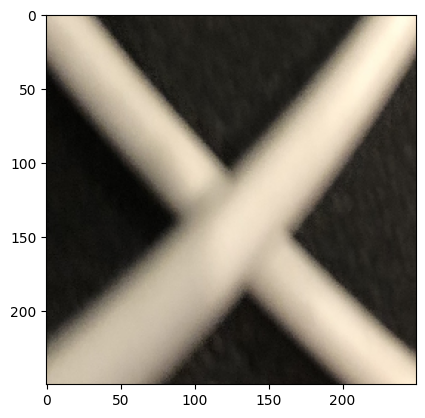

In [ ]:
show(0, imgs_val, lbls_val)

## Transformations and Training Dataset Expansion

In [ ]:
l = len(imgs_train)
x_flip_size = np.random.randint(l*2//10, l*3//10)
x_flip_idx = rn.sample(range(l), x_flip_size)

for i in x_flip_idx:
  img = imgs_train[i]
  imgs_train.append(np.fliplr(img))
  lbls_train = np.append(lbls_train, [1-lbls_train[i]], axis=0)

Label -2: 1


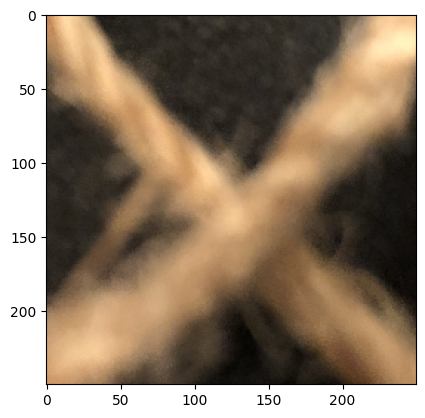

In [ ]:
show(-2, imgs_train, lbls_train)

In [ ]:
l = len(imgs_train)
y_flip_size = np.random.randint(l*2//10, l*3//10)
y_flip_idx = rn.sample(range(l), y_flip_size)

for i in y_flip_idx:
  img = imgs_train[i]
  imgs_train.append(np.flipud(img))
  lbls_train = np.append(lbls_train, [1-lbls_train[i]], axis=0)

Label -2: 0


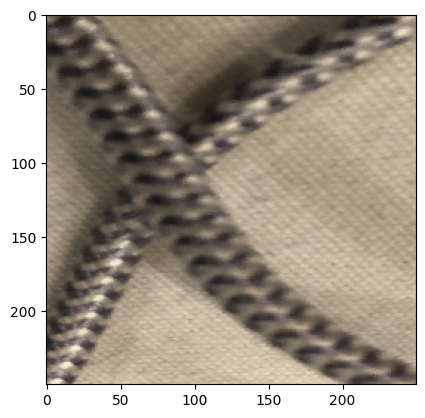

In [ ]:
show(-2, imgs_train, lbls_train)

In [ ]:
l = len(imgs_train)
color_size = np.random.randint(l*2//10, l*3//10)
color_idx = rn.sample(range(l), color_size)

for i in color_idx:
  img = imgs_train[i]

  red_scale = np.random.uniform(0.5, 1.5)
  green_scale = np.random.uniform(0.5, 1.5)
  blue_scale = np.random.uniform(0.5, 1.5)

  filtered_image_np = img.copy()
  filtered_image_np[..., 0] = np.clip(filtered_image_np[..., 0] * red_scale, 0, 1)
  filtered_image_np[..., 1] = np.clip(filtered_image_np[..., 1] * green_scale, 0, 1)
  filtered_image_np[..., 2] = np.clip(filtered_image_np[..., 2] * blue_scale, 0, 1)

  imgs_train.append(filtered_image_np)
  lbls_train = np.append(lbls_train, [lbls_train[i]], axis=0)

Label -2: 0


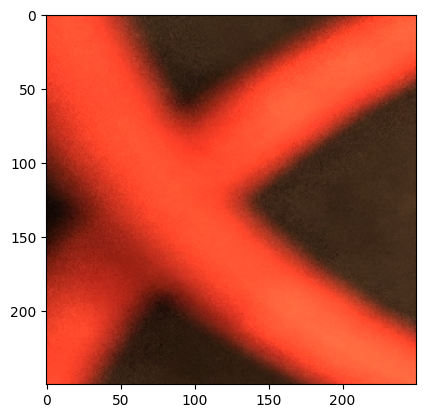

In [ ]:
show(-2, imgs_train, lbls_train)

In [ ]:
imgs_train = np.array(imgs_train)
imgs_val = np.array(imgs_val)
imgs_test = np.array(imgs_test)

In [ ]:
print(f"Expanded training dataset to {imgs_train.shape} images and {lbls_train.shape} labels.")

Expanded training dataset to (362, 250, 250, 3) images and (362,) labels.


## Mean and Standard Deviation

In [ ]:
flattened_images = imgs_train.reshape(-1, 3)

mean = flattened_images.mean(axis=0)
std = flattened_images.std(axis=0)

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: [0.45928048 0.34363861 0.29126938]
Std: [0.29398597 0.25030352 0.22182542]


In [ ]:
# mean = np.array([103.22054918, 88.2811744, 76.22403021])
# std = np.array([36.2723682, 31.77950203, 28.417094])

## Model

In [ ]:
class CrossingClassifier(nn.Module):
  def __init__(self, size, device='cuda', dropout_rate=0.2, layer_freeze="layer3"):
    super(CrossingClassifier, self).__init__()
    self.device = device
    self.to(self.device)

    self.w = size[0]
    self.h = size[1]
    self.mean = mean
    self.std = std

    self.transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((self.h, self.w)),
      transforms.ToTensor(),
      transforms.Normalize(self.mean, self.std)
    ])

    self.cnn = models.convnext_base(weights='DEFAULT')
    self._freeze_layers(layer_freeze)

    # cnn_out = self.cnn.fc.in_features
    cnn_out = self.cnn.classifier[2].in_features
    # self.cnn.classifier[2] = nn.Identity()
    # self.cnn.fc = nn.Identity()
    self.cnn.classifier[2] = nn.Identity()

    self.fc1 = nn.Linear(cnn_out, 32)
    self.fc2 = nn.Linear(32, 64)
    self.fc3 = nn.Linear(64, 16)
    self.fc4 = nn.Linear(16, 1)

    self.dropout = nn.Dropout(dropout_rate)

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

    self.train_losses = []
    self.val_losses = []
    self.best_val_loss = float('inf')
    self.best_state_dict = None
    self.patience_counter = 0

  def _freeze_layers(self, freeze_layer):
      freeze = True
      for name, param in self.cnn.named_parameters():
        if freeze:
          param.requires_grad = False
        if freeze_layer in name:
          break

  def forward(self, img):
    x = self.cnn(img)

    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.fc3(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.fc4(x)
    x = self.sigmoid(x)

    return x

  def normalize_imgs(self, imgs):
    if isinstance(imgs, torch.Tensor):
      imgs = imgs.numpy()
    tensor_imgs = torch.stack([self.transform(img) for img in imgs])

    return tensor_imgs

  def fit(self, imgs, y, val_imgs, val_y, num_epochs, batch_size, lr, patience=20):
    self.to(self.device)

    self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    self.criterion = nn.BCELoss().to(self.device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=5)

    X = self.normalize_imgs(imgs).to(self.device)
    y = torch.tensor(y).float().to(self.device)

    X_val = self.normalize_imgs(val_imgs).to(self.device)
    y_val = torch.tensor(val_y).float().to(self.device)

    dataset = TensorDataset(X, y)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    for epoch in range(num_epochs):
      epoch_train_losses = []
      self.train()

      for i, (batch_X, batch_y) in enumerate(train_loader):
        batch_X = batch_X.to(self.device)
        batch_y = batch_y.to(self.device)

        outputs = self.forward(batch_X)
        loss = self.criterion(outputs.squeeze(dim=1), batch_y)
        epoch_train_losses.append(loss.item())

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
        self.optimizer.step()

      avg_train_loss = np.mean(epoch_train_losses)
      self.train_losses.append(avg_train_loss)

      val_loss = self.evaluate(val_loader)
      self.val_losses.append(val_loss)

      scheduler.step(val_loss)

      if val_loss < self.best_val_loss:
        self.best_val_loss = val_loss
        self.best_state_dict = copy.deepcopy(self.state_dict())
        self.patience_counter = 0
      else:
        self.patience_counter += 1

      if self.patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

      if (epoch+1) % (num_epochs//10) == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}')

    self.save_model("convnext_v0_best", best=True)
    self.save_model("convnext_v0_final", best=False)



  def evaluate(self, val_loader):
    self.eval()
    total_loss = 0
    with torch.no_grad():
      for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(self.device)
        batch_y = batch_y.to(self.device)

        outputs = self.forward(batch_X)
        loss = self.criterion(outputs.squeeze(dim=1), batch_y)
        total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    self.train()
    return avg_loss

  def train_score(self):
    if self.train_losses == None:
      print("No training history available")
      return

    print(f'Final Training Loss: {self.train_losses[-1]:.4f}')
    print(f'Final Validation Loss: {self.val_losses[-1]:.4f}')

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(self.train_losses)-1), self.train_losses[1:], color="blue", label="Training Loss")
    plt.plot(range(len(self.val_losses)-1), self.val_losses[1:], color="red", label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("BCE Loss")
    plt.title("Training BCE Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

  def test_score(self, imgs_test, y_test):
    self.eval()
    with torch.no_grad():
      X_test = self.normalize_imgs(imgs_test)
      X_test = torch.tensor(x_test, dtype=torch.float32).to(self.device)

      y_pred = self.forward(X_test)
      y_pred = y_pred.cpu().squeeze().numpy()

      y_pred_binary = (y_pred > 0.5).astype(int)

      print(f'Test Accuracy: {accuracy_score(y_test, y_pred_binary)}')
      print(f'F1 Score: {f1_score(y_test, y_pred_binary)}')
      print(f'Precision: {precision_score(y_test, y_pred_binary)}')
      print(f'Recall: {recall_score(y_test, y_pred_binary)}')
      cm = confusion_matrix(y_test, y_pred_binary)
      ConfusionMatrixDisplay(cm).plot()

    self.train()
    return y_pred

  def save_model(self, name, best=False):
    time = dt.now().strftime("%y-%m-%d_%H-%M")
    f = f"{name}_{time}.pth"

    save_dict = {
        'model_state_dict': self.state_dict() if not best else self.best_state_dict,
        'transform_state': self.transform,
        'model_params': {
          'h': self.h,
          'w': self.w,
          'mean': self.mean,
          'std': self.std
      }
    }
    try:
      # Mount Google Drive if not already mounted
      if not os.path.exists('/content/drive'):
          drive.mount('/content/drive')

      save_dir = f"/content/drive/My Drive/Colab Notebooks/knots/models"
      os.makedirs(save_dir, exist_ok=True)

      fn = os.path.join(save_dir, f)

      torch.save(save_dict, fn)
      print(f"Model saved to Google Drive at: {fn}")

    except Exception as e:
      print(f"Error saving to Google Drive: {str(e)}")
      local_dir = '/content'
      os.makedirs(local_dir, exist_ok=True)
      fn = os.path.join(local_dir, f)

      torch.save(save_dict, fn)
      print(f"Model saved locally at: {fn}")

  def load_model(cls, name, device='cuda'):
    path = '/content/drive/My Drive/Colab Notebooks/knots/models/'+name+'.pth'
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    checkpoint = torch.load(path, map_location=device)

    model = cls(
        img_channels=checkpoint['model_params']['img_channels'],
        h=checkpoint['model_params']['h'],
        w=checkpoint['model_params']['w'],
        device=device
    )

    model.load_state_dict(checkpoint['model_state_dict'])

    model.mean = checkpoint['model_params']['mean']
    model.std = checkpoint['model_params']['std']
    model.transform = checkpoint['transform_state']

    return model

## Training and Testing

In [ ]:
model = CrossingClassifier((250, 250), device=device)

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:07<00:00, 48.7MB/s]


In [ ]:
model.fit(imgs_train, lbls_train, imgs_val, lbls_val, num_epochs=100, batch_size=20, lr=1e-3, patience=51)

Epoch: 10/100, Train Loss = 0.6606, Val Loss = 0.6504
Epoch: 20/100, Train Loss = 0.6042, Val Loss = 0.6101
Epoch: 30/100, Train Loss = 0.4619, Val Loss = 0.6072
Epoch: 40/100, Train Loss = 0.3788, Val Loss = 0.5311
Epoch: 50/100, Train Loss = 0.3989, Val Loss = 0.5241
Epoch: 60/100, Train Loss = 0.4174, Val Loss = 0.5287
Epoch: 70/100, Train Loss = 0.4447, Val Loss = 0.5288
Epoch: 80/100, Train Loss = 0.4177, Val Loss = 0.5288
Epoch: 90/100, Train Loss = 0.3947, Val Loss = 0.5288
Early stopping at epoch 94
Model saved to Google Drive at: /content/drive/My Drive/Colab Notebooks/knots/models/convnext_v0_best_24-12-02_21-22.pth
Model saved to Google Drive at: /content/drive/My Drive/Colab Notebooks/knots/models/convnext_v0_final_24-12-02_21-22.pth


Final Training Loss: 0.4066
Final Validation Loss: 0.5288


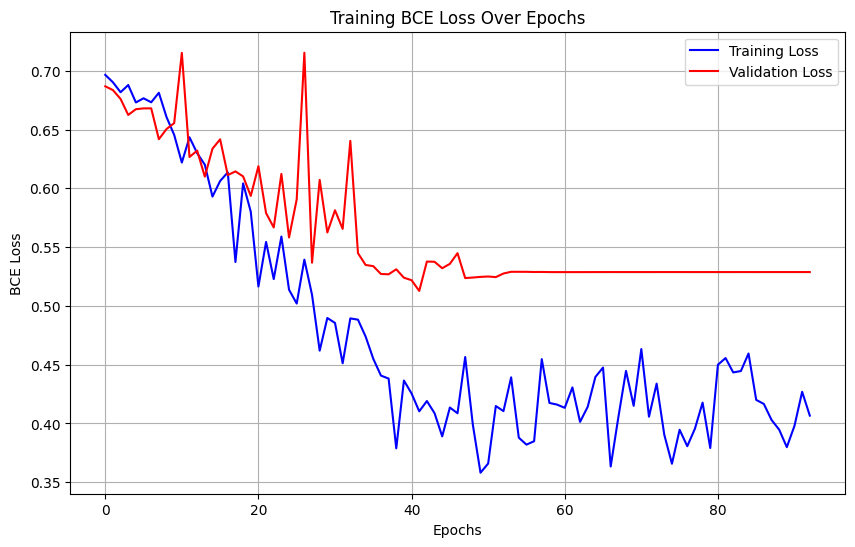

In [ ]:
model.train_score()

In [ ]:
preds = model.test_score(imgs_test, lbls_test)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor